# JP Morgan Mini Project 1

In [1]:
import pandas as pd 
import math
import operator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading dataset
nifty = pd.read_csv("NIFTY.csv") 
nifty.index = pd.to_datetime(nifty.Date)
nifty.describe()

,Open,High,Low,Close
count,250.000000,250.000000,250.000000,250.000000
mean,13367.213404,13435.472791,13261.676603,13355.313385
std,1706.866327,1713.182699,1694.558284,1706.141755
min,10323.799810,10401.049810,10267.349610,10302.099610
25%,11539.587890,11584.312257,11454.687260,11523.212408
50%,13761.500000,13831.399905,13660.174805,13754.899905
75%,14834.162603,14917.262700,14704.262452,14849.337402
max,15915.349610,15915.650390,15842.400390,15869.250000


In [3]:
# loading dataset
sgx_nifty = pd.read_csv("SGX Nifty.csv") 
sgx_nifty.index = pd.to_datetime(sgx_nifty.Date)
sgx_nifty.describe()

,Open,High,Low,Close
count,250.000000,250.000000,250.000000,250.000000
mean,2051.822601,2075.947193,2022.966408,2047.625007
std,124.753095,125.641820,122.249624,122.931349
min,1720.000000,1741.000000,1695.550049,1704.099976
25%,1959.399994,1977.450012,1932.000000,1956.375030
50%,2031.750000,2060.575074,2000.625000,2028.024964
75%,2140.762512,2166.500000,2105.500000,2134.025086
max,2325.000000,2369.350098,2310.550049,2324.550049


### Attempt 1 using Regression on prices:
Let nifty = f(sgx_nifty). In this attempt, the aim is to find the function f and then using assumption that Inda.P and Nifty are related in the same way as Nifty and SGX Nifty, we get Inda.P=f(nifty)

In [4]:
#Calculating mid value
nifty["Mid"]=nifty["High"]+nifty["Low"]
sgx_nifty["Mid"]=sgx_nifty["High"]+sgx_nifty["Low"]

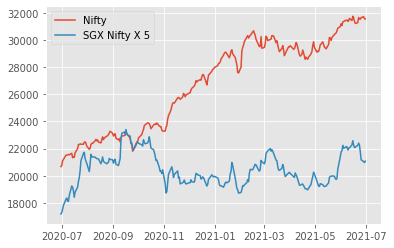

In [5]:
plt.plot(nifty.index, nifty["Mid"])
plt.plot(sgx_nifty.index, sgx_nifty["Mid"]*5)

plt.legend(["Nifty", "SGX Nifty X 5"])

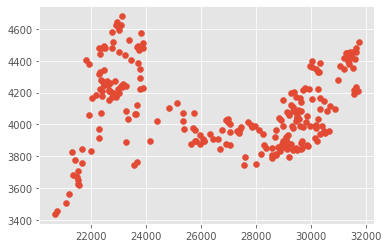

In [6]:
plt.scatter(nifty["Mid"],sgx_nifty["Mid"] )


Aim: To find relation between nifty and sgx nifty  
Based on above plot, it looked like a cubic function would be a better fit.
sgx_nifty=f(nifty) where, f can be a cubic function



**Cubic regression**

177.16572051443697
0.48103605495507396


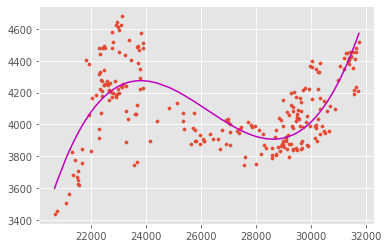

In [7]:
polynomial_features= PolynomialFeatures(degree=3)
x=nifty["Mid"]
x = x[:, np.newaxis]

x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
y=sgx_nifty["Mid"]
y = y[:, np.newaxis]
model.fit(x_poly,y )
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()


- From the above plot, sgx_nifty can be modelled approximately to a cubic function of nifty. Since above cubic function is not monotonic, we cannot find function f in this case.
- Instead of cubic function, we can model nifty as linear function of sgx_nifty, but clearly from the above scatter plot, linear function would not be a good fit.


### Approach 2 using Regression for Daily Price Change:


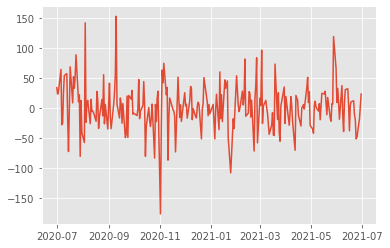

In [8]:
sgx_nifty["Daily_price_change"]=sgx_nifty["Close"].diff(periods=1)
plt.plot(sgx_nifty.index, sgx_nifty["Daily_price_change"])

<AxesSubplot:xlabel='Daily_price_change', ylabel='Density'>

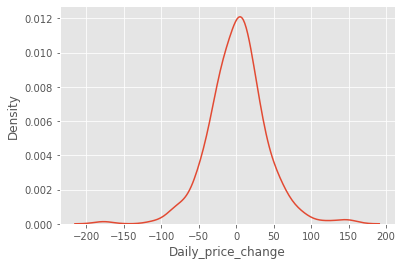

In [9]:
sns.kdeplot(data=sgx_nifty, x="Daily_price_change")

From the above plot it can be confirmed that Daily Change in Price for sgx_nifty approximately follows Gaussian Distribution.

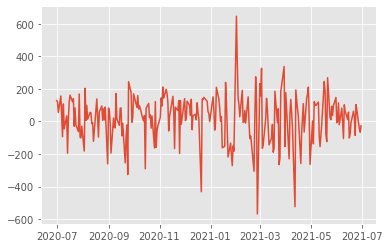

In [10]:
nifty["Daily_price_change"]=nifty["Close"].diff(periods=1)
plt.plot(nifty.index, nifty["Daily_price_change"])

<AxesSubplot:xlabel='Daily_price_change', ylabel='Density'>

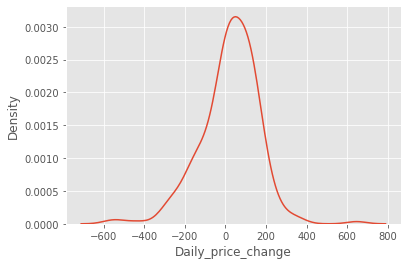

In [11]:
sns.kdeplot(data=nifty, x="Daily_price_change")

The plot for Daily Change in Price for nifty is a bit skewed towards the left.

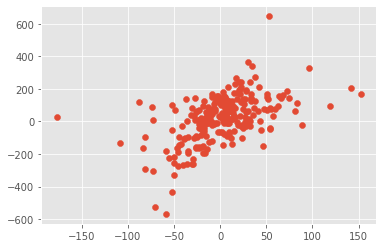

In [19]:
plt.scatter(sgx_nifty["Daily_price_change"],nifty["Daily_price_change"] )

120.707488557121
0.2888671866607583


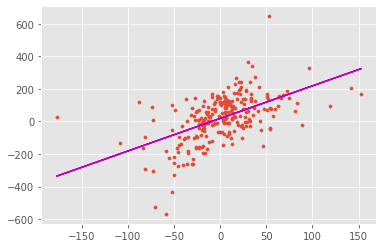

In [23]:
model = LinearRegression()
x=sgx_nifty[["Daily_price_change"]][1:]
y=nifty["Daily_price_change"][1:]
model.fit(x,y )
y_pred = model.predict(x)

rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)
print(rmse)
print(r2)

plt.scatter(x, y, s=10)

plt.plot(x, y_pred, color='m')
plt.show()


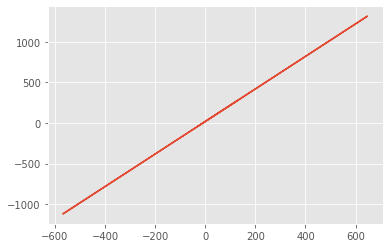

In [24]:
#Use the above model with x as nifty and y as inda.p

inda_p_daily_price_change = model.predict(nifty[["Daily_price_change"]][1:])
plt.plot(nifty["Daily_price_change"][1:], inda_p_daily_price_change)
plt.show()

In [25]:
# Standard deviation of inda.p
inda_p_daily_price_change.std()

286.7060524084118

- This approach cannot be used as the given standard deviation (i.e) 1.65(see next approach) is very different from the above value.
- Also this is change in daily price which is even larger than closing price (i.e)USD 110

### Approach 3 using Standard deviation and Correlation:  
(Here Daily Price Change was Assumed to be price difference (i.e) (current day closing price) - (previous day closing price)

#### Q1
- **Assumption:** Inda.P and Nifty have same correlation as Nifty and SGX Nifty = rho
- **Given:** 
    - Standard Deviation for Inda.P returns = 1.5 x 0.01
    - Closing price at 30th June 2021 = USD 110
- **Approach:**  
    - Find standard deviation of Inda.P Daily Price Change = sigma1 = (standard deviation for returns) x closing_price = 1.5 x 0.01 x 110
    - Find standard deviation of Nifty Daily Price Change = sigma2
    - Calculation rho
    - Covariance of Inda.P and Nifty = rho x sigma1 x sigma2

In [13]:
#Pearson correlation for Nifty and SGX Nifty
rho=nifty["Daily_price_change"][1:].corr(sgx_nifty["Daily_price_change"][1:])
rho

0.5374636607815992

In [14]:
#Standard deviation of Inda.P Daily Price Change (i.e) sigma1
sigma1=1.5*0.01*110
sigma1

1.65

In [15]:
#Standard deviation of Nifty Daily Price Change (i.e) sigma2
sigma2=nifty["Daily_price_change"].std()
sigma2

143.42758567581095

In [16]:
#Covariance of Inda.P and Nifty
covariance=rho*sigma1*sigma2
covariance

127.19374016973988

#### Q2
- **Assumptions:**
    - Mean of Daily Price Change for Inda.P is 0
    - Closing Prices is calculated for 1st July 2021
- **Given:**
    - Standard Deviation for Daily Price Change for Inda.P = sigma1 = 1.65
    - Closing price at 30th June 2021 = USD 110
    - z=1.96 for 95% CI
- **Approach:**
    - Calculate Confidence Interval for Daily Price Change of Inda.P using: 
    $$\mathrm{CI} = \bar{X} \pm (z \times \sigma_{\bar{X}})$$  
    $$\sigma_{\bar{X}} = \frac{s}{\sqrt{N}}$$     
    - Once the confidence interval is found, we can add closing price at 30th June 2021 (i.e) USD 110 to both left and right limits of the interval.
    


In [17]:
#Confidence interval for daily price change of Inda.P
N=nifty["Daily_price_change"].count()
CI=(1.96*sigma1)/math.sqrt(N)
CI


0.20494642261961615

In [18]:
#Range of Closing prices on 1st July 2021
print("[",110-CI,110+CI,"]")

[ 109.79505357738039 110.20494642261961 ]
